In [1]:
from time import time
import lightgbm as lgb
import numpy as np
import sys
# sys.path.append('..\Python Scripts\pipeline')
import warnings
warnings.filterwarnings('ignore') 
import seaborn as sns
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import KFold, TimeSeriesSplit
from scipy.stats import uniform
import datetime
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from scipy import stats
# from hyperopt import hp, tpe
# from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, validation_curve, KFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
%matplotlib inline
import gc
def reduce_memory_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object) & (col_type != 'datetime64[ns]'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum()/1024**2
    print('Memory usage: Before|{:.2f} MB || After|{:.2f} MB || Decreased|{:.1f}%'.format(start_mem, end_mem, 100*(1 - end_mem/start_mem)))
    
    return df 
def missing_values_table(df):
    '''
    Функция возвращает таблицу с количеством и долей пропущенных значений в датафрейме
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns
def reduce_mem_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object) & (col_type != 'datetime64[ns]'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum()/1024**2
    print('Memory usage: Before|{:.2f} MB || After|{:.2f} MB || Decreased|{:.1f}%'.format(start_mem, end_mem, 100*(1 - end_mem/start_mem)))
    
    return df 

In [2]:
main_path = r'../..'

import sys
sys.path.append(main_path)
from BayDS import *

Using TensorFlow backend.


In [57]:
with pd.HDFStore('F:\my\Prog\kaggle\Fraud\hdf\pre-aggregate-no-duplicates.h5') as store:
    data = store[f'data']

In [11]:
ind = data.index

In [58]:
train = data[data['isFraud'] != -1]
test = data[data['isFraud'] == -1]

In [12]:
del data
gc.collect()

7

In [ ]:
X = train.sort_index().drop(['isFraud'], axis=1)
y = train.sort_index()['isFraud'].astype(np.uint8)
test = test.sort_index()

X.drop('Date', axis=1, inplace=True)
X=X.astype(np.float32)
test.drop('Date', axis=1, inplace=True)
test=test.astype(np.float32)

In [4]:
del train
gc.collect()

49

In [20]:
def quick_score_anya(X_new, categorial_features, colname=None, replacement=None, target='isFraud', drop_columns=['Date'], filter_neg_target=True,
                isReplacementCategorial=False, params=None, n_estimators = 600):
    if params is None:
        params = {'num_leaves': 500,
                  'min_child_weight': 0.03454472573214212,
                  'feature_fraction': 0.3797454081646243,
                  'bagging_fraction': 0.4181193142567742,
                  'min_data_in_leaf': 106,
                  'objective': 'binary',
                  'max_depth': -1,
                  'learning_rate': 0.1,
                  "boosting_type": "gbdt",
                  "bagging_seed": 11,
                  "metric": 'auc',
                  "verbosity": -1,
                  'reg_alpha': 0.3899927210061127,
                  'reg_lambda': 0.6485237330340494,
                  'random_state': 47,
                  }


#     X_new = data.loc[train_subset_ids].drop(drop_columns + [target], axis=1)
#     if colname is not None:
#         assert replacement is not None
#         X_new[colname] = replacement.loc[train_subset_ids]
#     y = data.loc[train_subset_ids][target]

    folds = KFold(n_splits=5, shuffle=False)

    if isReplacementCategorial:
        raise Exception("Add replacement column as categorial")

    categorical_columns = [c for c, col in enumerate(X_new.columns) if col in categorial_features]

    params['categorical_feature'] = categorical_columns

    results = train_model_classification(X=X_new, X_test=None, y=y, params=params, folds=folds, splits=1,
                                         model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                         verbose=None, early_stopping_rounds=40, n_estimators=600, averaging='usual',
                                         n_jobs=-1)

    return sum(results['scores']) / len(results['scores']), results


In [15]:
timeaggs = pd.DataFrame(index=ind)
for i, cat in enumerate(['TransactionAmt', 'C1', 'C2', 'C6', 'C9', 'C11', 'C13', 'C14', 'id_02', 'D1', 'D2', 'D4', 'D8', 'D10', 'D15']):
    print(i, cat)
    timeaggs = pd.concat([timeaggs, reduce_mem_usage(pd.read_pickle(f'f:/my/Prog/kaggle/Baydin/Data/agg1/{cat}.pkl'))], axis=1)


0 TransactionAmt
Mem. usage decreased to 92.08 Mb (35.3% reduction)
1 C1
Mem. usage decreased to 92.08 Mb (35.3% reduction)
2 C2
Mem. usage decreased to 92.08 Mb (35.3% reduction)
3 C6
Mem. usage decreased to 92.08 Mb (35.3% reduction)
4 C9
Mem. usage decreased to 92.08 Mb (35.3% reduction)
5 C11
Mem. usage decreased to 92.08 Mb (35.3% reduction)
6 C13
Mem. usage decreased to 92.08 Mb (35.3% reduction)
7 C14
Mem. usage decreased to 92.08 Mb (35.3% reduction)
8 id_02
Mem. usage decreased to 92.08 Mb (35.3% reduction)
9 D1
Mem. usage decreased to 92.08 Mb (35.3% reduction)
10 D2
Mem. usage decreased to 92.08 Mb (35.3% reduction)
11 D4
Mem. usage decreased to 92.08 Mb (35.3% reduction)
12 D8
Mem. usage decreased to 92.08 Mb (35.3% reduction)
13 D10
Mem. usage decreased to 92.08 Mb (35.3% reduction)
14 D15
Mem. usage decreased to 92.08 Mb (35.3% reduction)


In [17]:
missing_values_table(timeaggs)

Your selected dataframe has 240 columns.
There are 232 columns that have missing values.


,Missing Values,% of Total Values
D8_by_card_id_ws1d_to_std,999342,91.099999999999994
D8_by_card_id_ws2d_to_std,989774,90.200000000000003
D8_by_card_id_ws5_to_std,986620,89.900000000000006
D8_by_card_id_ws3d_to_std,984784,89.799999999999997
D8_by_card_id_ws7d_to_std,975847,88.900000000000006
D8_by_card_id_ws10_to_std,971321,88.500000000000000
D8_by_card_id_ws30d_to_std,965684,88.000000000000000
D8_by_card_id_ws100_to_std,957896,87.299999999999997
D8_by_card_id_ws5_to_mean,948671,86.500000000000000
D8_by_card_id_ws1d_to_mean,948651,86.500000000000000


In [33]:
timetrain = timeaggs.loc[:3577539]

In [23]:
corr = timetrain.corr()

In [26]:
corr[corr>0.9]

Index(['TransactionAmt_by_card_id_ws1d_to_mean',
       'TransactionAmt_by_card_id_ws1d_to_std',
       'TransactionAmt_by_card_id_ws2d_to_mean',
       'TransactionAmt_by_card_id_ws2d_to_std',
       'TransactionAmt_by_card_id_ws3d_to_mean',
       'TransactionAmt_by_card_id_ws3d_to_std',
       'TransactionAmt_by_card_id_ws7d_to_mean',
       'TransactionAmt_by_card_id_ws7d_to_std',
       'TransactionAmt_by_card_id_ws30d_to_mean',
       'TransactionAmt_by_card_id_ws30d_to_std',
       ...
       'D15_by_card_id_ws7d_to_mean', 'D15_by_card_id_ws7d_to_std',
       'D15_by_card_id_ws30d_to_mean', 'D15_by_card_id_ws30d_to_std',
       'D15_by_card_id_ws5_to_mean', 'D15_by_card_id_ws5_to_std',
       'D15_by_card_id_ws10_to_mean', 'D15_by_card_id_ws10_to_std',
       'D15_by_card_id_ws100_to_mean', 'D15_by_card_id_ws100_to_std'],
      dtype='object', length=240)

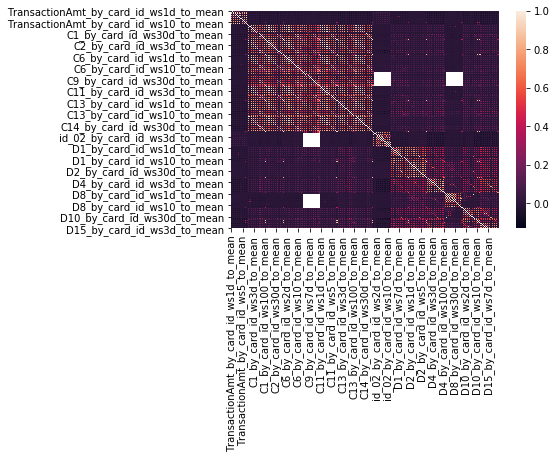

In [19]:
import seaborn as sns
sns.heatmap(timetrain.corr())

In [42]:
# highest = pd.read_csv('f:\my\Prog\kaggle\Baydin\ieee_with_additions.csv')

Fold 5 started at Tue Sep 10 10:52:55 2019
CV mean score: 0.8478, std: 0.0000.


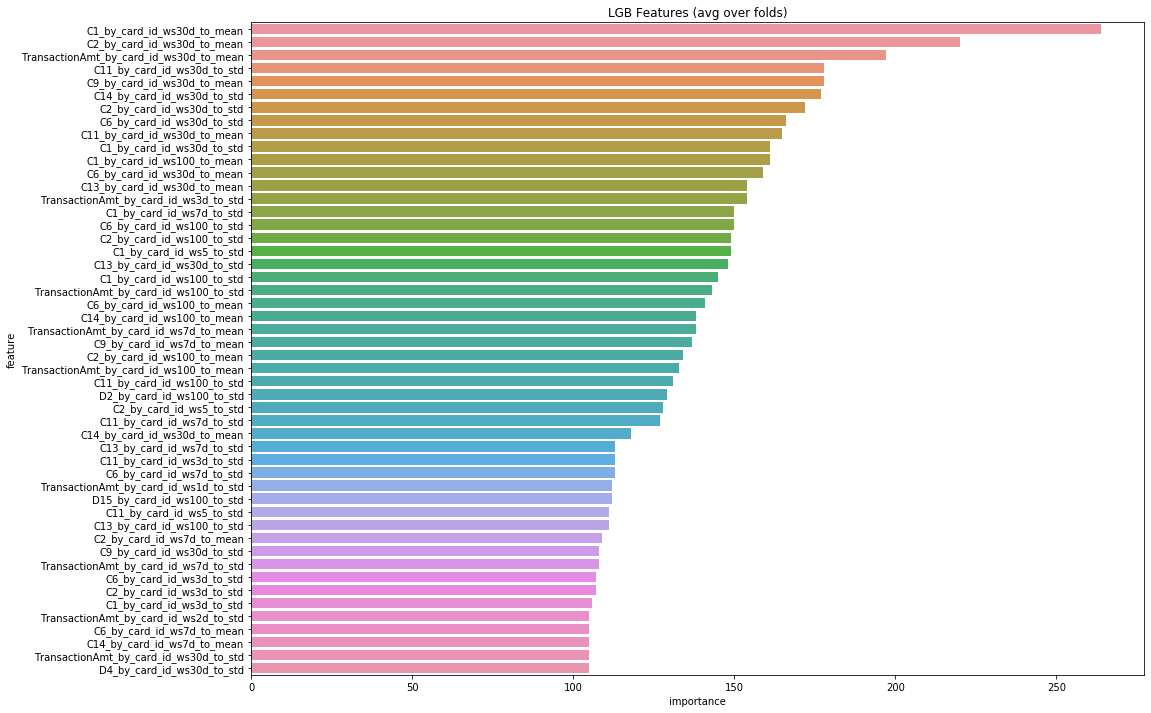

In [21]:
a, res = quick_score_anya(timetrain, y)

In [22]:
res['feature_importance'].sort_values(by='importance', ascending=False)

,feature,importance,fold
24,C1_by_card_id_ws30d_to_mean,264.0,5
40,C2_by_card_id_ws30d_to_mean,220.0,5
8,TransactionAmt_by_card_id_ws30d_to_mean,197.0,5
89,C11_by_card_id_ws30d_to_std,178.0,5
72,C9_by_card_id_ws30d_to_mean,178.0,5
121,C14_by_card_id_ws30d_to_std,177.0,5
41,C2_by_card_id_ws30d_to_std,172.0,5
57,C6_by_card_id_ws30d_to_std,166.0,5
88,C11_by_card_id_ws30d_to_mean,165.0,5
25,C1_by_card_id_ws30d_to_std,161.0,5


In [27]:
from sklearn.ensemble import IsolationForest
import numpy as np

In [28]:
timetrain

,TransactionAmt_by_card_id_ws1d_to_mean,TransactionAmt_by_card_id_ws1d_to_std,TransactionAmt_by_card_id_ws2d_to_mean,TransactionAmt_by_card_id_ws2d_to_std,TransactionAmt_by_card_id_ws3d_to_mean,TransactionAmt_by_card_id_ws3d_to_std,TransactionAmt_by_card_id_ws7d_to_mean,TransactionAmt_by_card_id_ws7d_to_std,TransactionAmt_by_card_id_ws30d_to_mean,TransactionAmt_by_card_id_ws30d_to_std,...,D15_by_card_id_ws7d_to_mean,D15_by_card_id_ws7d_to_std,D15_by_card_id_ws30d_to_mean,D15_by_card_id_ws30d_to_std,D15_by_card_id_ws5_to_mean,D15_by_card_id_ws5_to_std,D15_by_card_id_ws10_to_mean,D15_by_card_id_ws10_to_std,D15_by_card_id_ws100_to_mean,D15_by_card_id_ws100_to_std
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,1.000000000000,NaN,1.000000000000,NaN,1.0000000000000,NaN,1.00000000000,NaN,1.0000000000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,1.000000000000,NaN,1.000000000000,NaN,1.0000000000000,NaN,1.00000000000,NaN,1.0000000000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,1.000000000000,NaN,1.000000000000,NaN,1.0000000000000,NaN,1.00000000000,NaN,1.0000000000000,NaN,...,1.000000000000000,NaN,1.000000000000000,NaN,1.000000000000000,NaN,1.000000000000000,NaN,1.000000000000000,NaN
2987003,1.000000000000,NaN,1.000000000000,NaN,1.0000000000000,NaN,1.00000000000,NaN,1.0000000000000,NaN,...,1.000000000000000,NaN,1.000000000000000,NaN,1.000000000000000,NaN,1.000000000000000,NaN,1.000000000000000,NaN
2987004,1.000000000000,NaN,1.000000000000,NaN,1.0000000000000,NaN,1.00000000000,NaN,1.0000000000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987005,1.000000000000,NaN,1.000000000000,NaN,1.0000000000000,NaN,1.00000000000,NaN,1.0000000000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987006,1.000000000000,NaN,1.000000000000,NaN,1.0000000000000,NaN,1.00000000000,NaN,1.0000000000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987007,1.000000000000,NaN,1.000000000000,NaN,1.0000000000000,NaN,1.00000000000,NaN,1.0000000000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987008,1.000000000000,NaN,1.000000000000,NaN,1.0000000000000,NaN,1.00000000000,NaN,1.0000000000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
timetrain.replace(np.inf, -999, inplace=True)
timetrain.replace(-np.inf, -999, inplace=True)
timetrainnonan = timetrain.fillna(-999)


In [61]:
train.replace(np.inf, -999, inplace=True)
train.replace(-np.inf, -999, inplace=True)
train = train.fillna(-999)

In [62]:
clf = IsolationForest( behaviour = 'new', max_samples=1000, random_state = 0, contamination= 'auto')
preds = clf.fit_predict(train.drop('Date', axis=1))
preds

MemoryError: could not allocate 2362160 bytes

In [49]:
timetrainnonan.iloc[:, :10].shape

(590540, 10)

In [47]:
preds.sum()

555672

In [55]:
len(np.where(preds == -1)[0])

17434

In [54]:
len(np.where(preds == 1)[0])

573106

In [50]:
timetrainnonan.shape

(590540, 240)

In [67]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

In [55]:
n_fold = 5
folds = KFold(n_splits=n_fold)

In [68]:
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 2045,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold
    
}

In [ ]:
result_dict_lgb = train_model_classification(X=X, X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

Fold 1 started at Tue Sep 10 10:04:14 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.982741	training's auc: 0.982741	valid_1's auc: 0.907948	valid_1's auc: 0.907948


In [ ]:
columns_forward = list(X.drop('Date', axis=1).columns)

list_to_add = columns_forward.copy()
list_start = []
temp_df_score = pd.DataFrame(columns=['feature', 'train', 'test'])


X_train, X_test, y_train, y_test = train_test_split(X_num_agg, y, stratify = y, test_size = 0.3, random_state=0)


while len(list_to_add) != 0:
    forward_iteration = forward(list_start, columns_forward, X_train, X_test, y_train, y_test, params)

    temp_df_score = temp_df_score.append(forward_iteration, ignore_index=True)
    print(temp_df_score)
    var = forward_iteration.values[0][0]
    list_start.append(var)
    list_to_add.remove(var)
    print(var)

In [ ]:
def forward(vars_list, all_vars, X_train, X_test, y_train, y_test, params):
    res=[]
    q=0
    
    for col in list(set(all_vars) - set(vars_list)):
        q+=1
        vars_stay = vars_list + [col]
        
        lgb = lightgbm.LGBMClassifier(**params)
        lgb.fit(X_train[vars_stay], y_train, eval_set=[(X_test[vars_stay], y_test)], 
                        eval_metric='auc', verbose=False, early_stopping_rounds=100,) 
        
        tr = roc_auc_score(y_train, lgb.predict_proba(X_train[vars_stay])[:,1])
        te = roc_auc_score(y_test, lgb.predict_proba(X_test[vars_stay])[:,1])
        
        res.append([col, tr, te])
        print(q, ' feature: ', col,  '\ttrain: ', round(tr, 3),  '\ttest: ', round(te, 3))
                    
    forw = pd.DataFrame(res, columns = ['feature', 'train', 'test'])
    forw['train_mean'] = forw['train']
    return forw.sort_values(by='train_mean', ascending=False)[['feature', 'train', 'test']].reset_index(drop=True).loc[:0, :]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(agg1, y, stratify = y, test_size = 0.3, random_state = 0)